In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import yaml

In [3]:
with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)


In [4]:
labels = glob("../label/*.json")
labels.sort()

In [5]:
# Read the json file
with open(labels[-1]) as f:
    data = json.load(f)
    print(f)

<_io.TextIOWrapper name='../label/project-4-at-2024-02-28-13-20-6d80512c.json' mode='r' encoding='UTF-8'>


In [6]:
entities = []
relations = []
sent_entities = []
sent_relations = []

for sentence in data:
    t_entities = []
    t_relations = []
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            entities.append(annotation["value"]["labels"][0])
            t_entities.append(annotation["value"]["labels"][0])
        elif annotation["type"] == "relation":
            relations.append(annotation["labels"])
    sent_entities.append(list(set(t_entities)))
 #   sent_relations.append(list(set(relations)))

In [7]:
relations = [item for items in relations for item in items]
#entities = [item for items in entities for item in items]
sent_entities = [item for items in sent_entities for item in items]

In [8]:
pd.DataFrame(sent_entities).value_counts()

0         
STRAIN        2341
METABOLITE     861
ORGANISM       842
EFFECT         721
PROTEIN        695
SPECIES        681
ISOLATE        484
COMPOUND       472
PHENOTYPE      347
MEDIUM         340
GENE           257
DISEASE        242
GENUS          183
MORPHOLOGY     159
VIRUS           98
ASSEMBLY         7
Name: count, dtype: int64

In [9]:
ner_df = pd.DataFrame(sent_entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_sentence"})

Text(0.5, 1.0, 'Number of sentences with entity')

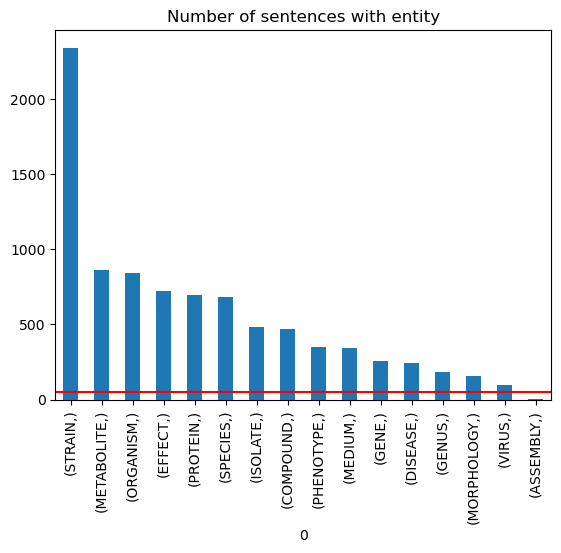

In [10]:
pd.DataFrame(sent_entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Number of sentences with entity')

In [11]:
ner_df = ner_df.merge(pd.DataFrame(entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_entity"}))


Text(0.5, 1.0, 'Total number of entities')

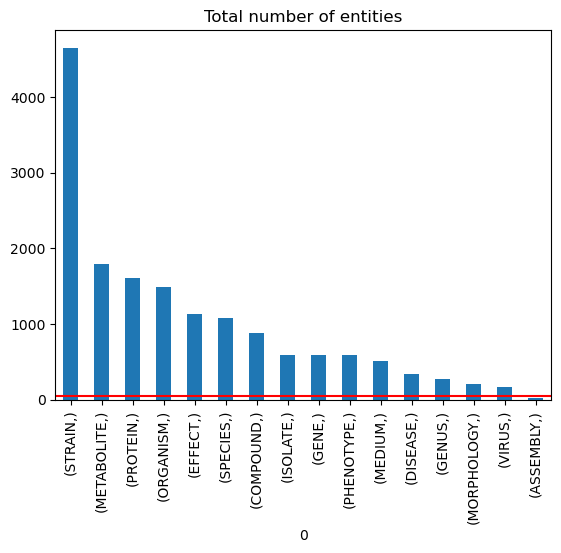

In [12]:
pd.DataFrame(entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Total number of entities')

In [13]:
ner_df_m = ner_df.melt("ner", var_name="type", value_name="count")

In [14]:
ner_df_m

,ner,type,count
0,STRAIN,count_per_sentence,2341
1,METABOLITE,count_per_sentence,861
2,ORGANISM,count_per_sentence,842
3,EFFECT,count_per_sentence,721
4,PROTEIN,count_per_sentence,695
5,SPECIES,count_per_sentence,681
6,ISOLATE,count_per_sentence,484
7,COMPOUND,count_per_sentence,472
8,PHENOTYPE,count_per_sentence,347
9,MEDIUM,count_per_sentence,340


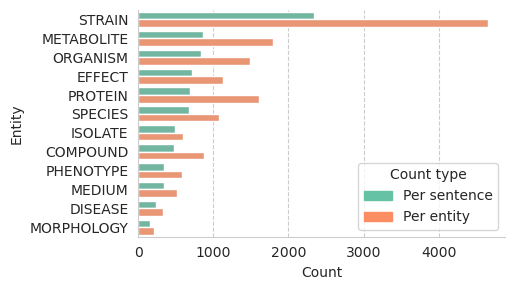

In [15]:
import matplotlib.patches as mpatches

# Define the colors for the legend
colors = ["#66c2a5", "#fc8d62"]

# Create the patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ["Per sentence", "Per entity"])]

# Set the style to show faint vertical grid lines
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.3})

# Plot the graph
sns.catplot(y="ner", x="count", hue="type", kind="bar", data=ner_df_m[ner_df_m["ner"].isin(config["ner_labels"])], palette="Set2", legend=False, height=3, aspect=1.75)
plt.xlabel("Count")
plt.ylabel("Entity")
plt.legend(handles=patches, title="Count type")

plt.savefig("./figures/predictions/labeled_entities_counts.pdf")

### RELS

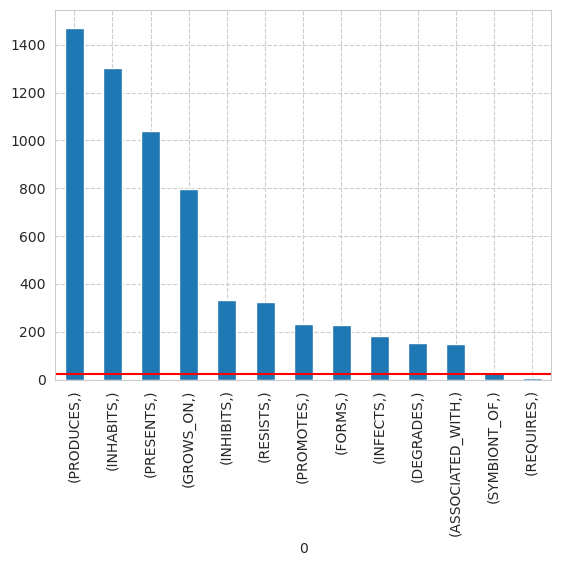

In [16]:
pd.DataFrame(relations).value_counts().plot(kind='bar')
plt.axhline(25, color='red')

In [17]:
sentence_id = []
sentence_text = []
relationships = []
for sentence in data:
    ids = {} # id -> label dictionary
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            ids[annotation["id"]] = annotation["value"]["labels"]
#            text[annotation["id"]] = annotation["value"]["text"]
        elif annotation["type"] == "relation":
#            print(ids.get(annotation["from_id"]),"->", ids.get(annotation["to_id"]), ":", annotation["labels"])
            s = str(*ids.get(annotation["from_id"]))+"->"+ str(*ids.get(annotation["to_id"]))+ ":"+ str(*annotation["labels"])
            relationships.append(s)
            sentence_text.append(sentence["data"]["text"])
            sentence_id.append(sentence["id"])

In [18]:
df = pd.DataFrame({"sentence_id":sentence_id, "text" : sentence_text,"relationship":relationships})

In [19]:
grouped = df.groupby(["sentence_id", "relationship"]).count().reset_index()
filtered = grouped[grouped["relationship"] == "STRAIN->ISOLATE:INHABITS"]

Make split using `pd.sample`

In [20]:
counts = pd.DataFrame(relationships).value_counts()

In [21]:
df[df["relationship"]=="STRAIN->DISEASE:PROMOTES"]

,sentence_id,text,relationship
4060,9580,Enterobacter cloacae strain SENG-6 expresses A...,STRAIN->DISEASE:PROMOTES


In [22]:
cnts = counts.reset_index()

In [23]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>0)].set_index(0)

,count
0,
STRAIN->ISOLATE:INHABITS,896
STRAIN->METABOLITE:PRODUCES,788
STRAIN->MEDIUM:GROWS_ON,770
STRAIN->PHENOTYPE:PRESENTS,619
STRAIN->PROTEIN:PRODUCES,469
STRAIN->ORGANISM:INHABITS,341
STRAIN->EFFECT:PRESENTS,235
STRAIN->MORPHOLOGY:FORMS,216
STRAIN->COMPOUND:RESISTS,162


Text(0, 0.5, '')

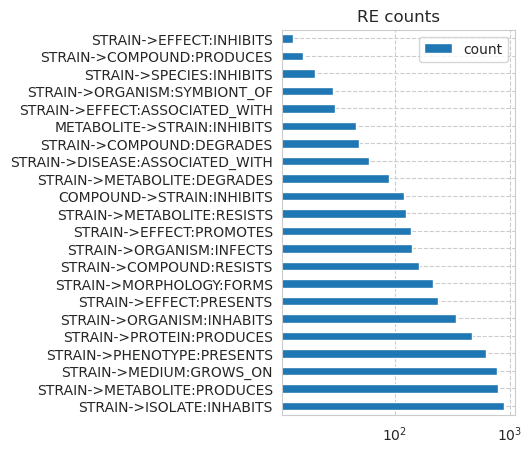

In [24]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>12)].set_index(0).plot(kind='barh',figsize=(3,5),logx=True)
plt.title("RE counts")
plt.ylabel("")

In [25]:
c = cnts.rename(columns={0:"relationship"})

In [26]:
c["re"] = c.relationship.str.split(":",expand=True)[1]
c["ner_re"] = c.relationship.str.split(":",expand=True)[0]

In [27]:
c["non_strain_ner"] = c.relationship.str.split(":", expand=True)[0].str.split("->").apply(lambda x: [elem for elem in x if elem != "STRAIN"])


In [28]:
c["relationship"] = c.relationship.str.replace("->", "-")
c["ner_re"] = c["ner_re"].str.replace("->", "-")

In [29]:
cs = c[c['non_strain_ner'].apply(lambda x: len(x) == 1)]


In [30]:
cs.set_index("re")[["ner_re", "count"]]

,ner_re,count
re,,
INHABITS,STRAIN-ISOLATE,896
PRODUCES,STRAIN-METABOLITE,788
GROWS_ON,STRAIN-MEDIUM,770
PRESENTS,STRAIN-PHENOTYPE,619
PRODUCES,STRAIN-PROTEIN,469
INHABITS,STRAIN-ORGANISM,341
PRESENTS,STRAIN-EFFECT,235
FORMS,STRAIN-MORPHOLOGY,216
RESISTS,STRAIN-COMPOUND,162


In [31]:
cs.set_index("re")[["ner_re", "count"]]

,ner_re,count
re,,
INHABITS,STRAIN-ISOLATE,896
PRODUCES,STRAIN-METABOLITE,788
GROWS_ON,STRAIN-MEDIUM,770
PRESENTS,STRAIN-PHENOTYPE,619
PRODUCES,STRAIN-PROTEIN,469
INHABITS,STRAIN-ORGANISM,341
PRESENTS,STRAIN-EFFECT,235
FORMS,STRAIN-MORPHOLOGY,216
RESISTS,STRAIN-COMPOUND,162


In [32]:
cs['non_strain_ner'] = cs['non_strain_ner'].explode()


/tmp/ipykernel_211352/975501423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['non_strain_ner'] = cs['non_strain_ner'].explode()


In [33]:
cs_filter = cs[(cs["count"]>10)&(cs["non_strain_ner"]!="VIRUS")]

In [34]:
pivot_df = cs_filter.pivot_table(index='re', columns='non_strain_ner', values='count', aggfunc='sum').fillna(0)


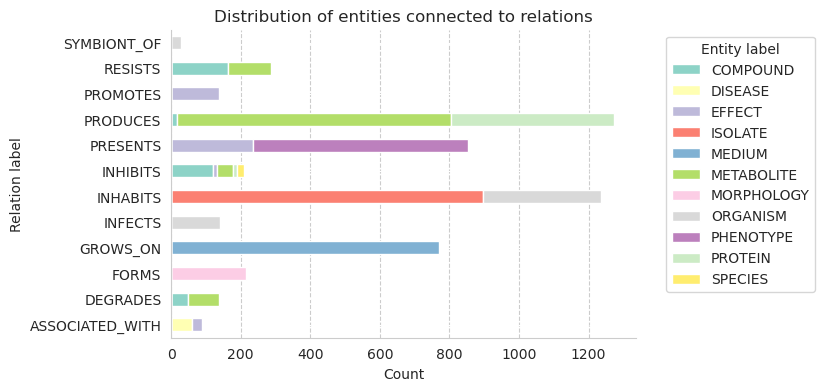

In [35]:
pivot_df.plot(kind='barh', stacked=True, colormap='Set3', figsize=(6, 4))

plt.xlabel('Count')
plt.ylabel('Relation label')
plt.title('Distribution of entities connected to relations')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Entity label")

# Remove horizontal axis lines in the background
plt.grid(axis='y', which='both', color='white')

# Remove the right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig("./figures/predictions/relationship_distribution.pdf", bbox_inches='tight')